In [1]:
import sys
# necessary to find ros packages
sys.path.append('/opt/ros/humble/local/lib/python3.10/dist-packages')

import numpy as np
import matplotlib.pyplot as plt
import yaml

from models.point import Point
from models.map import Map
from models.pose import Pose
from utils.classify_points import classify_points
from utils.extract_track_borders import extract_track_borders
from utils.get_center_line import get_center_line
from utils.trajectory_from_points import trajectory_from_path
import math

from path_find_algorithms.A_star.A_star import AStar

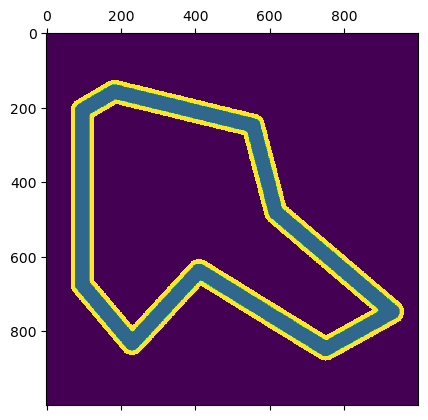

In [2]:
with open('../../../to_be_saved/occupancy_grid.npy', 'rb') as f:
    occupancy_grid = np.load(f)

with (open('../../../to_be_saved/occupancy_grid_info.yaml', 'rb')) as f:
    occupancy_grid_config = yaml.safe_load(f)

occupancy_grid_filtered = (occupancy_grid >30)*1

# classify points
point_inside_track = Point(400, 200)
classified_grid = classify_points(point_inside_track, occupancy_grid_filtered)

plt.matshow(classified_grid)

# For some reason the maps come with an resolution offset
resolution = occupancy_grid_config["resolution"]
classification_map = Map(classified_grid, resolution, Point(occupancy_grid_config["origin_x"] - resolution, occupancy_grid_config["origin_y"] -resolution))

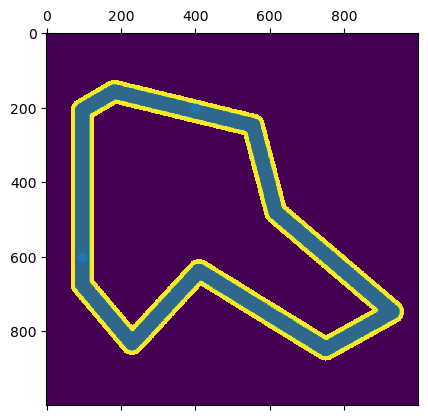

In [3]:
start = Point(400, 200)
goal = Point(94, 600)
plt.matshow(classification_map.grid)
plt.scatter([start.x, goal.x ], [start.y, goal.y])


backsolve


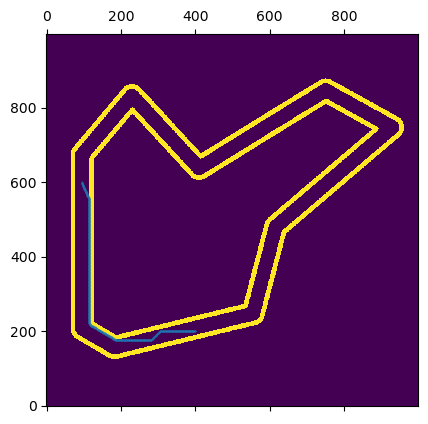

In [4]:

path = AStar.find_path(start, goal, classification_map.grid)

plt.matshow(occupancy_grid_filtered)
plt.scatter([point.x for point in path], [point.y for point in path], s=0.1)
plt.gca().invert_yaxis()

In [5]:
# Create Trajectory from Path
trajectory = trajectory_from_path(path, classification_map)
# Write into file
with open('../../../to_be_saved/trajectory.txt', 'r+') as f:
    for pose in trajectory:
        f.write(f"{pose.coordinate.x},{pose.coordinate.y},{pose.quaternion.x}, {pose.quaternion.y}, {pose.quaternion.z}, {pose.quaternion.w}\n")


## Generate center line of track

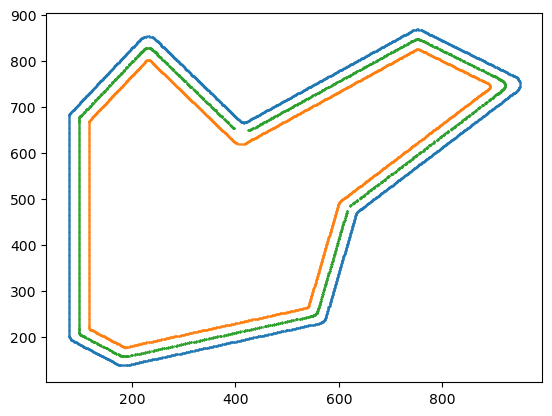

In [26]:
track_borders = extract_track_borders(classification_map.grid)
assert len(track_borders) == 2
center_line = get_center_line(track_borders[0], track_borders[1])

for line in [*track_borders, center_line]:
    plt.scatter([p.x for p in line], [p.y for p in line], s=0.1)

In [172]:
from scipy import interpolate
from scipy import ndimage

def smooth_path(path: list[Point], window_size=10, limit_factor=2, interpolation_steps=1000):
    points = np.empty(shape=(len(path), 2))
    for i, point in enumerate(path):
        points[i] = [point.x, point.y]

    # remove duplicates from trajectory
    _, idx = np.unique(points, axis=0, return_index=True)
    uniques = points[np.sort(idx)]

    x = uniques[:,0]
    y = uniques[:,1]

    # smooth trajectory
    jump = np.sqrt(np.diff(x)**2 + np.diff(y)**2) 
    smooth_jump = ndimage.gaussian_filter1d(jump, window_size, mode='wrap')  # window of size 5 is arbitrary
    limit = limit_factor*np.median(smooth_jump)    # factor 2 is arbitrary
    x_smoothed, y_smoothed = x[:-1], y[:-1]
    x_smoothed = x_smoothed[(jump > 0) & (smooth_jump < limit)]
    y_smoothed = y_smoothed[(jump > 0) & (smooth_jump < limit)]

    x_smoothed = np.r_[x_smoothed, x[-1]]
    y_smoothed = np.r_[y_smoothed, y[-1]]
    



    tck, u = interpolate.splprep([x_smoothed,y_smoothed], s=0, per=True)
    x_int, y_int = interpolate.splev(np.linspace(0,1, 1000), tck)
    trajectory_smoothed = [Point(x,y) for (x,y) in zip(x_int, y_int)]
    return trajectory_smoothed
    

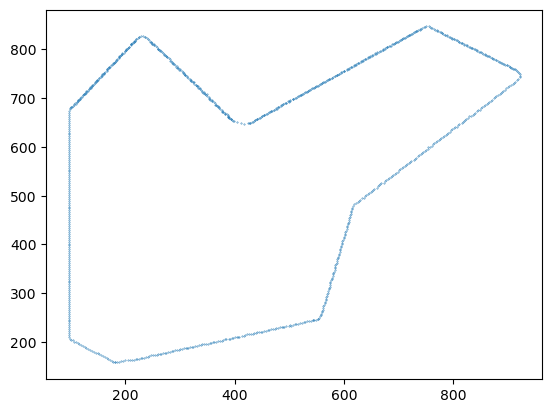

In [176]:
trajectory_smoothed = smooth_path(center_line, window_size=10)
plt.scatter([p.x for p in trajectory_smoothed], [p.y for p in trajectory_smoothed], s=0.1)
#trajectory_smoothed = smooth_path(center_line, window_size=10)
#plt.scatter([p.x for p in trajectory_smoothed], [p.y for p in trajectory_smoothed], s=0.1)

In [186]:
# Write into file
trajectory = trajectory_from_path(trajectory_smoothed, classification_map)
with open('../../../to_be_saved/trajectory.txt', 'w') as f:
    for pose in trajectory[:-int(0.1 * len(trajectory))]:
        f.write(f"{pose.coordinate.x},{pose.coordinate.y},{pose.quaternion.x},{pose.quaternion.y},{pose.quaternion.z},{pose.quaternion.w}\n")
